In [1]:
!pip install vit-keras
!pip install tensorflow-addons
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from PIL import Image
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
import vit_keras
from vit_keras import vit

D:\CSE299\Flutter\Anaconda\envs\Best\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
D:\CSE299\Flutter\Anaconda\envs\Best\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

In [2]:
# Set random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)

In [3]:
# 1. Load and preprocess the dataset
def load_image_data(image_folder, image_size=(224, 224)):  # ViT uses 224x224 images
    images, labels = [], []
    
    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(image_folder, filename)
            image = Image.open(img_path).convert('RGB')
            
            # Resize the image to 224x224 (ViT input size)
            image = image.resize(image_size)
            
            # Convert image to numpy array
            image_array = np.array(image)
            images.append(image_array)
            
            # Extract the label from the filename (e.g., '000_0.jpg' -> label is 0)
            label = int(filename.split('_')[1].split('.')[0])
            labels.append(label)
    
    return np.array(images), np.array(labels)

# Define your dataset folder path
image_folder = "D:\\RESEARCH_WORK\\Teeth_Segmentation_Project\\Label_Dataset"
images, labels = load_image_data(image_folder, image_size=(224, 224))

# Normalize images (0-255 pixel values to 0-1)
images = images / 255.0

# Convert labels to categorical format
labels = to_categorical(labels, num_classes=2)


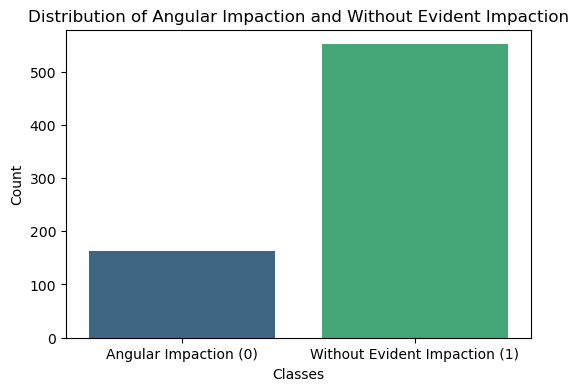

In [4]:
# 2. Exploratory Data Analysis (optional)
label_counts = pd.Series([np.argmax(label) for label in labels]).value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Angular Impaction and Without Evident Impaction')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks([0, 1], ['Angular Impaction (0)', 'Without Evident Impaction (1)'])
plt.show()

In [5]:
# 3. Split data into Train (80%), Validation (10%), and Test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Further split the remaining 20% into Validation (10%) and Test (10%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f'Training set shape: {X_train.shape}, {y_train.shape}')
print(f'Validation set shape: {X_val.shape}, {y_val.shape}')
print(f'Test set shape: {X_test.shape}, {y_test.shape}')

Training set shape: (570, 224, 224, 3), (570, 2)
Validation set shape: (71, 224, 224, 3), (71, 2)
Test set shape: (72, 224, 224, 3), (72, 2)


In [6]:
# 4. Apply Random Over Sampler to balance classes
ros = RandomOverSampler(random_state=42)
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flat, np.argmax(y_train, axis=1))
X_train_resampled = X_train_resampled.reshape((-1, 224, 224, 3))  # Reshape after oversampling
y_train_resampled = to_categorical(y_train_resampled, num_classes=2)


In [7]:
# 5. Create ViT model using vit_keras library
def create_vit_model():
    # Using ViT from the vit_keras library (ViT-B16 is Base 16x16 patch size)
    vit_model = vit.vit_b16(
        image_size=224,
        pretrained=True,
        include_top=False,
        pretrained_top=False
    )
    
    # Freeze the base layers of ViT
    vit_model.trainable = False
    
    # Add custom layers on top of ViT
    x = Flatten()(vit_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer for binary classification (2 classes)
    output = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=vit_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [8]:
# 6. Model Summary
model = create_vit_model()
model.summary()

347502902/347502902 [==============================] - 734s 2us/step


D:\CSE299\Flutter\Anaconda\envs\Best\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))        

In [9]:
# 7. Train the model
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True
)

# Fit the datagen to the training data
datagen.fit(X_train_resampled)

# Training
history = model.fit(
    datagen.flow(X_train_resampled, y_train_resampled, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20,
    verbose=1
)

Epoch 1/20
28/28 [==============================] - 204s 7s/step - loss: 0.9672 - accuracy: 0.5263 - val_loss: 0.8427 - val_accuracy: 0.3944
Epoch 2/20
28/28 [==============================] - 203s 7s/step - loss: 0.8328 - accuracy: 0.5458 - val_loss: 0.6325 - val_accuracy: 0.5634
Epoch 3/20
28/28 [==============================] - 204s 7s/step - loss: 0.7718 - accuracy: 0.5778 - val_loss: 0.6766 - val_accuracy: 0.5352
Epoch 4/20
28/28 [==============================] - 205s 7s/step - loss: 0.7338 - accuracy: 0.5870 - val_loss: 0.8253 - val_accuracy: 0.4085
Epoch 5/20
28/28 [==============================] - 205s 7s/step - loss: 0.7091 - accuracy: 0.5881 - val_loss: 0.6162 - val_accuracy: 0.6338
Epoch 6/20
28/28 [==============================] - 207s 7s/step - loss: 0.6886 - accuracy: 0.6007 - val_loss: 0.6290 - val_accuracy: 0.6056
Epoch 7/20
28/28 [==============================] - 206s 7s/step - loss: 0.6487 - accuracy: 0.6293 - val_loss: 0.5830 - val_accuracy: 0.7042
Epoch 8/20
28

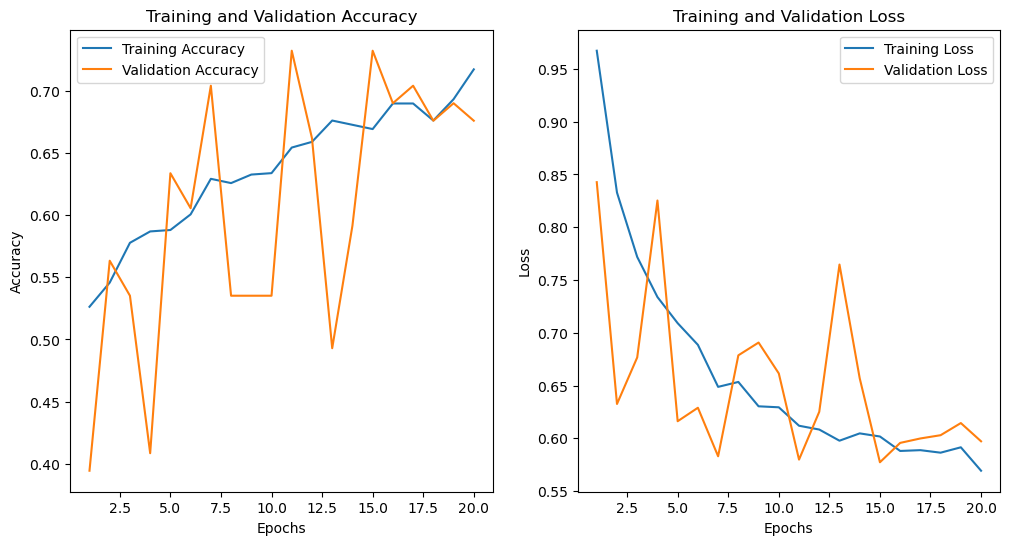

In [10]:
# 8. Plot Accuracy and Loss Curves
def plot_training_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    # Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_training_curves(history)

3/3 [==============================] - 15s 3s/step


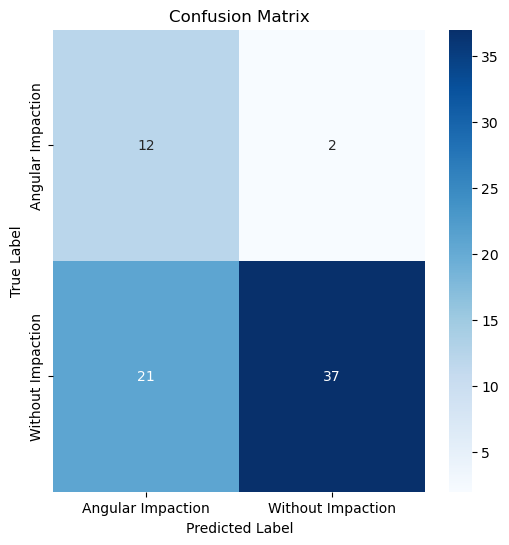

Classification Report:
                   precision    recall  f1-score   support

Angular Impaction       0.36      0.86      0.51        14
Without Impaction       0.95      0.64      0.76        58

         accuracy                           0.68        72
        macro avg       0.66      0.75      0.64        72
     weighted avg       0.83      0.68      0.71        72



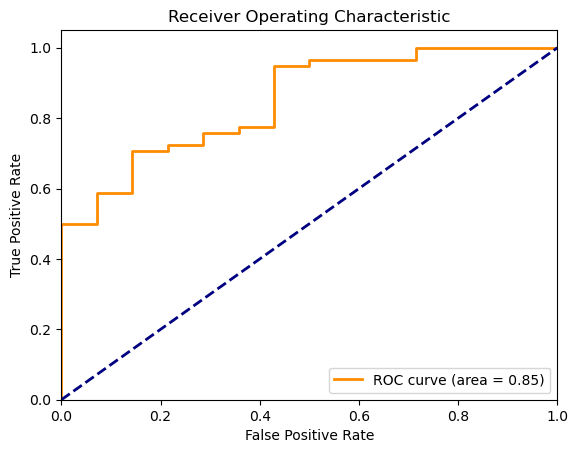

In [11]:
# 9. Evaluate the model and generate metrics
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Angular Impaction', 'Without Impaction'], 
            yticklabels=['Angular Impaction', 'Without Impaction'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Angular Impaction', 'Without Impaction']))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()